In [ ]:
!pip install pyspellchecker

In [69]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [51]:
################################ Train data cleaning #########################
#load train data
train = pd.read_csv("drive/My Drive/disaster_tweets/train.csv")

In [ ]:
# function to clean  text
def clean_tweets(text):
  text = re.sub(r'@(\w+)', 'at', text)  #at
  text = re.sub(r'(\d+):(\d+)', 'time', text)  #time
  text = re.sub(r'(\d+)', 'num', text)  #number
  text = re.sub(r'(http|https)?://\S+.\S+',  'link', text)  #link
  text = re.sub(r'(\W+)', ' ', text)  #remove all special characters
  return text

examp = "hi https://www.gfng.org.com this is 543 @fr 21:00 ??"
print(clean_tweets(examp))

In [50]:
#function to spellcheck
spellcheck = SpellChecker()
def spell_check(text):
  new_text =  []
  mispelled = spellcheck.unknown(text.split())
  for word in text.split():
    if word in mispelled:
      new_text.append(spellcheck.correction(word))
    else:
      new_text.append(word)
  new_text = ' '.join(new_text)
  return new_text
spell_check("helo too yuo al")

'help too you al'

In [52]:
#APPLY on train
train.text = train.text.apply(lambda x: clean_tweets(x))
train.text = train.text.apply(lambda x: spell_check(x))
train.text.head()

0    Our Deeds are the Reason of this earthquake Ma...
1                Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are be...
3    num num people receive wildfire evacuation ord...
4    Just got sent this photo from Ruby Alaska as s...
Name: text, dtype: object

In [54]:
#stemming
stemmer = PorterStemmer()
def stem(text):
  for i in text:
    l =[]
    for word in text.split():
      l.extend([stemmer.stem(word)])
    l = ' '.join(l)
    return l
examp =  "have to going housing"
stem(examp)

'have to go hous'

In [56]:
train.text = train.text.apply(lambda x: stem(x))
train.head() #okay

,id,keyword,location,text,target
0,1,NaN,NaN,our deed are the reason of thi earthquak may a...,1
1,4,NaN,NaN,forest fire near La rong sask canada,1
2,5,NaN,NaN,all resid ask to shelter in place are be notif...,1
3,6,NaN,NaN,num num peopl receiv wildfir evacu order in ca...,1
4,7,NaN,NaN,just got sent thi photo from rubi alaska as sm...,1


In [59]:
############################## Feature Engineering ####################
#create new features- like counts
#count of 'link', 'time', 'num', 'at
def count_word(text, word):
  count_word = text.split().count(word)
  return count_word
examp = "hi link is n ot a guy, he is a link"
count_word(examp, 'a')

2

In [66]:
#create features
link_list = train.text.apply(lambda x: count_word(x, 'link'))
num_list = train.text.apply(lambda x: count_word(x, 'num'))
time_list = train.text.apply(lambda x: count_word(x, 'time'))
at_list = train.text.apply(lambda x: count_word(x, 'at'))

train['link_count'] = link_list
train['num_count'] = num_list
train['time_count'] = time_list
train['at_count'] = at_list

train.head()

,id,keyword,location,text,target,link_count,num_count,time_count,at_count
0,1,NaN,NaN,our deed are the reason of thi earthquak may a...,1,0,0,0,0
1,4,NaN,NaN,forest fire near La rong sask canada,1,0,0,0,0
2,5,NaN,NaN,all resid ask to shelter in place are be notif...,1,0,0,0,0
3,6,NaN,NaN,num num peopl receiv wildfir evacu order in ca...,1,0,2,0,0
4,7,NaN,NaN,just got sent thi photo from rubi alaska as sm...,1,0,0,0,0


In [70]:

#vectorize text data and concat new numerical features
tfidf_obj = TfidfVectorizer(max_features=1000)
tfidf_text = tfidf_obj.fit_transform(train.text)

In [88]:
#combine all column for training
train_data = pd.DataFrame(tfidf_text.toarray()).join(train.iloc[:, 5:])
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,link_count,num_count,time_count,at_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [85]:
################################## NN with new features ############################
model = keras.Sequential()
model.add(keras.layers.Dense(32,input_dim = train_data.shape[1], activation=keras.activations.relu))
model.add(keras.layers.Dense(16, activation=keras.activations.relu))
model.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))

model.compile(optimizer='sgd', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                32160     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 32,705
Trainable params: 32,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit model
model.fit(train_data, train.target, batch_size = 50, epochs = 100, verbose = 2)

In [92]:
#training saturates at 85% accuracy
#Let's predict
test = pd.read_csv("drive/My Drive/disaster_tweets/test.csv")

In [93]:
test.text = test.text.apply(lambda x: clean_tweets(x))
test.text = test.text.apply(lambda x: spell_check(x))
test.text = test.text.apply(lambda x: stem(x))
test.text

0                         just happen a terribl car crash
1       heard about earthquak is differ citi stay safe...
2       there is a forest fire at spot pond gees are f...
3                          apocalyps light spokan wildfir
4           typhoon soudelor kill num in china and taiwan
                              ...                        
3258      earthquak safeti lo angel ÛÒ safeti fasten xrwn
3259    storm in RI wors than last hurrican My citi am...
3260                    green line derail in chicago link
3261             meg issu hazard weather outlook hwo link
3262    cityofcalgari ha activ it municip emerg plan y...
Name: text, Length: 3263, dtype: object

In [ ]:
#create features
link_list = test.text.apply(lambda x: count_word(x, 'link'))
num_list = test.text.apply(lambda x: count_word(x, 'num'))
time_list = test.text.apply(lambda x: count_word(x, 'time'))
at_list = test.text.apply(lambda x: count_word(x, 'at'))

test['link_count'] = link_list
test['num_count'] = num_list
test['time_count'] = time_list
test['at_count'] = at_list

test.head()

In [ ]:
tfidf_test = tfidf_obj.fit_transform(test.text)
test_data = pd.DataFrame(tfidf_test.toarray()).join(test.iloc[:, 4:])
test_data.tail()

In [ ]:
#predict
pred = model.predict(test_data, verbose=1)
pred[pred>0.5] = 1
pred[pred <=0.5] = 0
pred

In [113]:
#view entire test data with text and prediction
result = pd.DataFrame(test.text).join(pd.DataFrame(np.round(pred).astype(int)))

In [ ]:
result.tail(20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f545a3f15c0>]],
      dtype=object)

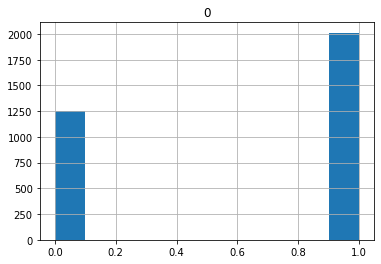

In [114]:
pd.DataFrame(pred).hist()

In [134]:
#submit
sub = pd.DataFrame(test.id).join(pd.DataFrame(pred))

In [145]:
sub.columns = ['id', 'target']
sub = sub.drop(sub.index[[3263]], axis=0)

In [150]:
test.head()

,id,keyword,location,text,link_count,num_count,time_count,at_count
0,0,NaN,NaN,just happen a terribl car crash,0,0,0,0
1,2,NaN,NaN,heard about earthquak is differ citi stay safe...,0,0,0,0
2,3,NaN,NaN,there is a forest fire at spot pond gees are f...,0,0,0,1
3,9,NaN,NaN,apocalyps light spokan wildfir,0,0,0,0
4,11,NaN,NaN,typhoon soudelor kill num in china and taiwan,0,1,0,0


In [151]:
sub.to_csv('disaster_predictions.csv')

In [152]:
train_data.to_csv("train_ready_data.csv")
test_data.to_csv("test_ready_data.csv")